In [1]:
# -*- coding: UTF-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd()

'C:\\Users\\nclab\\Desktop'

In [2]:
csv_data = pd.read_excel('C:\\Users\\nclab\\Desktop\\top.xlsx')
csv_data.groupby('商品ID').describe().transpose()
data = csv_data[csv_data.columns[:-7]]
df4 = csv_data.dropna(axis=1)
df4['date'] = pd.to_datetime(df4['下单时间'])
df4.set_index('date').resample('D')['订购数量'].sum()
df4.set_index('date').resample('D')['订单金额'].sum()
df4['HOUR'] = pd.to_datetime(df4['date']).dt.hour
df4['DAY'] = pd.to_datetime(df4['date']).dt.day
df8 = df4[['商品ID','订购数量','订单金额','HOUR','DAY','date']]
df8 = df8.sort_values('date').groupby(['商品ID', 'HOUR', 'DAY'], as_index=False)
df8 = df8.agg({'订单金额':['sum', 'mean'], '订购数量':['sum', 'mean','count']})
df8.columns = ['商品ID', 'HOUR', 'DAY', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
item_ids = df8['商品ID'].unique()
DAY_list=[ 4,  5,  6,  7,  9,  8, 10]
HOUR_list=[ 0,  1,  2,  3,  4,  5, 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,19, 20, 21, 22, 23]
empty_df = []
for day in DAY_list:
    for hour in HOUR_list:
        for item in item_ids:
            empty_df.append([hour, day, item])
    
empty_df = pd.DataFrame(empty_df, columns=['HOUR','DAY','商品ID'])
train_daily = pd.merge(empty_df, df8, on=['HOUR','DAY','商品ID'], how='left')
train_daily.fillna(0, inplace=True)
train_daily['item_cnt_hour'] = train_daily.sort_values(['DAY', 'HOUR'], ascending=[True,True]).groupby([ '商品ID'])['item_cnt'].shift(-1)
gp_item_price = train_daily.sort_values(['DAY', 'HOUR'], ascending=[True,True]).groupby(['商品ID'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['商品ID', 'hist_min_item_price', 'hist_max_item_price']
train_daily = pd.merge(train_daily, gp_item_price, on='商品ID', how='left')
train_daily['price_increase'] = train_daily['item_price'] - train_daily['hist_min_item_price']
train_daily['price_decrease'] = train_daily['hist_max_item_price'] - train_daily['item_price']
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_daily[('item_cnt_%s' % function_name[i])] = train_daily.sort_values(['DAY', 'HOUR'], ascending=[True,True]).groupby([ '商品ID'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_daily['item_cnt_std'].fillna(0, inplace=True)
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_daily[ft_name] = train_daily.sort_values(['DAY', 'HOUR'], ascending=[True,True]).groupby([ '商品ID'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_daily[ft_name].fillna(0, inplace=True)
train_daily['item_trend'] = train_daily['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_daily['item_trend'] -= train_daily[ft_name]

train_daily['item_trend'] /= len(lag_list) + 1
def generate_date_block(day,hour):
    return day*24+hour
train_daily['date_block_num'] = train_daily.apply(lambda row: generate_date_block(row['DAY'], row['HOUR']), axis=1)

C:\Users\nclab\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\nclab\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nclab\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [3]:
train_daily[train_daily.isnull().values==True]

,HOUR,DAY,商品ID,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_hour,hist_min_item_price,...,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,date_block_num
1670,23,10,12834035594,0.0,0.00,1.0,1.0,1.0,NaN,0.0,...,341.3,1.0,4.0,3.000000,1.732051e+00,4.0,4.0,9.0,-4.00,263.0
1671,23,10,13972131078,0.0,0.00,0.0,0.0,0.0,NaN,0.0,...,1402.8,0.0,0.0,0.000000,2.080834e-07,0.0,0.0,0.0,0.00,263.0
1672,23,10,13972883321,0.0,0.00,0.0,0.0,0.0,NaN,0.0,...,676.0,0.0,4.0,1.333333,2.309401e+00,0.0,4.0,0.0,-1.00,263.0
1673,23,10,23711570817,311.2,311.20,2.0,2.0,1.0,NaN,0.0,...,986.7,2.0,6.0,3.666667,2.081666e+00,6.0,3.0,3.0,-2.50,263.0
1674,23,10,24488925934,317.1,317.10,2.0,2.0,1.0,NaN,0.0,...,950.4,2.0,3.0,2.333333,5.773503e-01,3.0,2.0,2.0,-1.25,263.0
1675,23,10,26393731157,0.0,0.00,0.0,0.0,0.0,NaN,0.0,...,1276.0,0.0,1.0,0.333333,5.773503e-01,1.0,0.0,1.0,-0.50,263.0
1676,23,10,28114312956,628.3,314.15,3.0,1.5,2.0,NaN,0.0,...,754.5,1.0,3.0,2.000000,1.000000e+00,2.0,1.0,3.0,-0.75,263.0
1677,23,10,28415217148,391.0,195.50,3.0,1.5,2.0,NaN,0.0,...,879.5,0.0,3.0,2.000000,1.732051e+00,0.0,3.0,4.0,-1.00,263.0
1678,23,10,29637978858,0.0,0.00,0.0,0.0,0.0,NaN,0.0,...,2871.0,0.0,3.0,1.000000,1.732051e+00,3.0,0.0,0.0,-0.75,263.0
1679,23,10,31290879573,876.0,219.00,4.0,1.0,4.0,NaN,0.0,...,2628.0,0.0,4.0,1.666667,2.081666e+00,0.0,1.0,1.0,0.50,263.0


In [4]:
train_set = train_daily.query('date_block_num >= 96 and date_block_num < 217').copy()
validation_set = train_daily.query('date_block_num >= 217 and date_block_num <= 263').copy()


train_set.dropna(subset=['item_cnt_hour'], inplace=True)
validation_set.dropna(subset=['item_cnt_hour'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])


print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_daily.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_daily.shape[0])*100)))

Train set records: 1210
Validation set records: 460
Train set records: 1210 (72% of complete data)
Validation set records: 460 (27% of complete data)


In [5]:
# Item mean encoding.
gp_item_mean = train_daily.groupby(['商品ID']).agg({'item_cnt_hour': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# day mean encoding.
gp_day_mean = train_daily.groupby(['DAY']).agg({'item_cnt_hour': ['mean']})
gp_day_mean.columns = ['day_mean']
gp_day_mean.reset_index(inplace=True)
# hour mean encoding.
gp_hour_mean = train_daily.groupby(['HOUR']).agg({'item_cnt_hour': ['mean']})
gp_hour_mean.columns = ['HOUR_mean']
gp_hour_mean.reset_index(inplace=True)
# Add meand encoding features to train set.

train_set = pd.merge(train_set, gp_item_mean, on=['商品ID'], how='left')
train_set = pd.merge(train_set, gp_day_mean, on=['DAY'], how='left')
train_set = pd.merge(train_set, gp_hour_mean, on=['HOUR'], how='left')
# Add meand encoding features to validation set.

validation_set = pd.merge(validation_set, gp_item_mean, on=['商品ID'], how='left')

validation_set = pd.merge(validation_set, gp_day_mean, on=['DAY'], how='left')
validation_set = pd.merge(validation_set, gp_hour_mean, on=['HOUR'], how='left')

In [6]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_hour', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_hour'].astype(int)
X_validation = validation_set.drop(['item_cnt_hour', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_hour'].astype(int)

In [7]:
import datetime
import warnings
import seaborn as sns
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\nclab\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0:	learn: 2.8045733	test: 1.8588173	best: 1.8588173 (0)	total: 104ms	remaining: 52s
50:	learn: 2.1866629	test: 1.4564691	best: 1.4564691 (50)	total: 844ms	remaining: 7.43s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.456469062
bestIteration = 50

Shrink model to first 51 iterations.
Model params: {'max_ctr_complexity': 4, 'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 25, 'loss_function': 'RMSE', 'depth': 4, 'iterations': 500}
Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


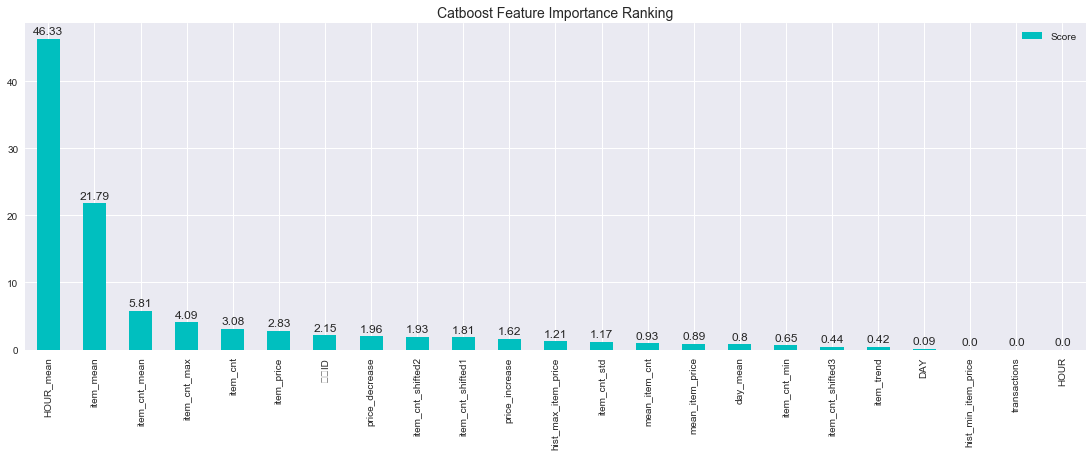

Train rmse: 2.18672469139699
Validation rmse: 1.4564690615543696


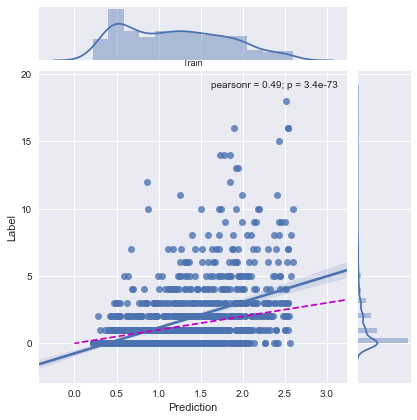

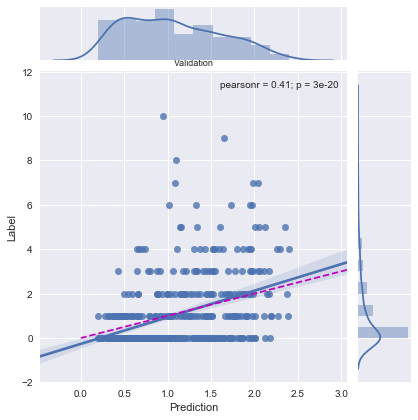

In [8]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)
print('Model params:', catboost_model.get_params())
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg")
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

[0]	validation_0-rmse:2.56377	validation_1-rmse:1.6441
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:2.39493	validation_1-rmse:1.64168
Stopping. Best iteration:
[6]	validation_0-rmse:2.44162	validation_1-rmse:1.59295

Train rmse: 2.441626811346212
Validation rmse: 1.592947951456021


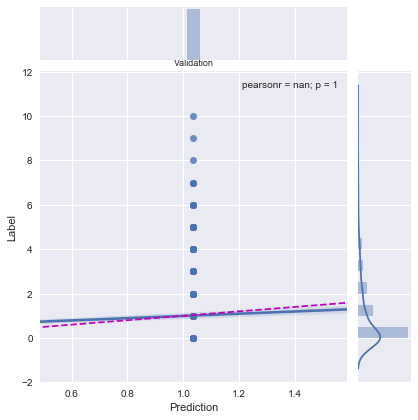

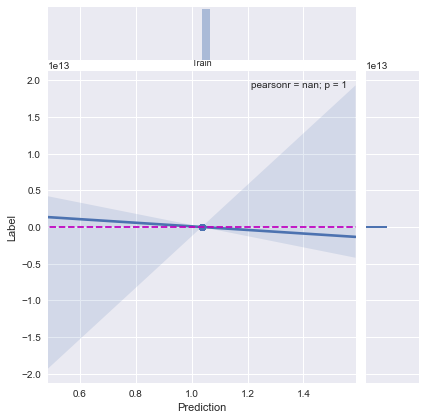

In [9]:
# Use only part of features on XGBoost.
xgb_features = ['item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend', ]

xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')
model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')

In [10]:
X_train[X_train.isnull().values==True]

,HOUR,DAY,商品ID,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,hist_min_item_price,hist_max_item_price,...,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,item_mean,day_mean,HOUR_mean


Train rmse: 2.2914688425376526
Validation rmse: 1.5426584957003953


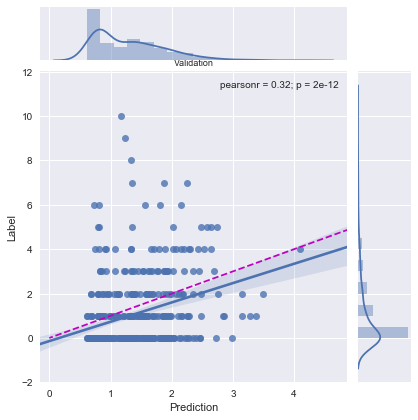

In [11]:
# Use only part of features on linear Regression.
lr_features = ['item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

Train rmse: 1.6261677304642672
Validation rmse: 2.029403424868886


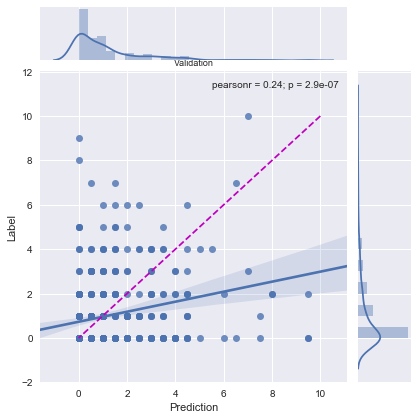

In [12]:
knn_features =['item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend']
knn_train = X_train[knn_features]
knn_val = X_validation[knn_features]
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_model = KNeighborsRegressor(n_neighbors=2, leaf_size=200, n_jobs=-1)
knn_model.fit(knn_train, Y_train)
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

Train rmse: 1.6457206014758547
Validation rmse: 1.6062908662866089


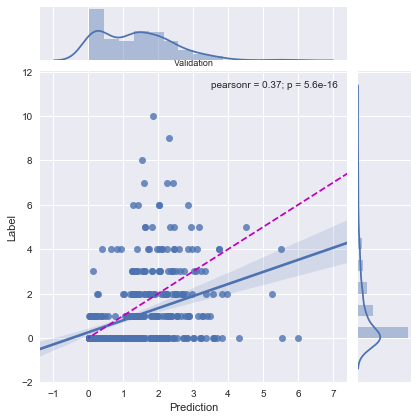

In [13]:
rf_features = ['HOUR','DAY','商品ID','item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

In [14]:
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.57,1.04,0.15,1.52,1.00,1
1,0.31,1.04,0.05,0.81,0.00,0
2,0.20,1.04,0.02,0.68,0.00,0
3,0.37,1.04,0.04,0.80,0.50,0
4,0.40,1.04,0.01,1.14,2.50,0
5,0.32,1.04,0.17,0.85,1.00,1
6,0.55,1.04,0.05,1.19,0.00,0
7,0.42,1.04,0.04,0.80,0.00,0
8,0.49,1.04,0.51,1.50,0.00,0
9,0.52,1.04,0.14,1.69,0.00,0


Train rmse: 1.4428527656026569


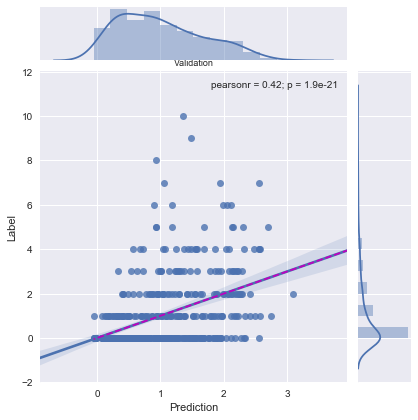

In [15]:
meta_model = LinearRegression(n_jobs=-1)
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)
ensemble_pred = meta_model.predict(first_level)
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

In [17]:
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

Using TensorFlow backend.


In [36]:
mlp_features = ['item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3',
       'item_trend']
mlp_train = X_train[mlp_features]
mlp_val = X_validation[mlp_features]
epochs = 40
batch = 32
lr = 0.00003
adam = optimizers.Adam(lr)
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=mlp_train.shape[1]))
model_mlp.add(Dense(10,activation='relu'))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               1800      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________


In [37]:
mlp_history = model_mlp.fit(mlp_train.values, Y_train, validation_data=(mlp_val.values, Y_validation), epochs=200, verbose=2)

Train on 1210 samples, validate on 460 samples
Epoch 1/200
 - 1s - loss: 15686.6330 - val_loss: 7191.8088
Epoch 2/200
 - 0s - loss: 4129.3265 - val_loss: 1331.7430
Epoch 3/200
 - 0s - loss: 1383.8780 - val_loss: 355.3366
Epoch 4/200
 - 0s - loss: 941.1892 - val_loss: 288.8691
Epoch 5/200
 - 0s - loss: 806.0250 - val_loss: 276.2965
Epoch 6/200
 - 0s - loss: 705.9075 - val_loss: 266.8083
Epoch 7/200
 - 0s - loss: 622.0534 - val_loss: 253.6715
Epoch 8/200
 - 0s - loss: 549.9243 - val_loss: 236.9787
Epoch 9/200
 - 0s - loss: 485.5053 - val_loss: 218.0044
Epoch 10/200
 - 0s - loss: 425.4749 - val_loss: 195.0939
Epoch 11/200
 - 0s - loss: 375.1546 - val_loss: 176.1326
Epoch 12/200
 - 0s - loss: 328.2410 - val_loss: 160.0370
Epoch 13/200
 - 0s - loss: 285.4163 - val_loss: 137.5329
Epoch 14/200
 - 0s - loss: 249.4953 - val_loss: 119.4456
Epoch 15/200
 - 0s - loss: 218.5476 - val_loss: 105.4144
Epoch 16/200
 - 0s - loss: 189.0899 - val_loss: 90.7169
Epoch 17/200
 - 0s - loss: 165.0867 - val_los

Epoch 151/200
 - 0s - loss: 7.2565 - val_loss: 3.9157
Epoch 152/200
 - 0s - loss: 7.6723 - val_loss: 4.1238
Epoch 153/200
 - 0s - loss: 7.1278 - val_loss: 3.8268
Epoch 154/200
 - 0s - loss: 7.1963 - val_loss: 3.7917
Epoch 155/200
 - 0s - loss: 7.2694 - val_loss: 4.1614
Epoch 156/200
 - 0s - loss: 7.1996 - val_loss: 3.9203
Epoch 157/200
 - 0s - loss: 7.1645 - val_loss: 3.7761
Epoch 158/200
 - 0s - loss: 7.1495 - val_loss: 3.7499
Epoch 159/200
 - 0s - loss: 7.1131 - val_loss: 3.8892
Epoch 160/200
 - 0s - loss: 7.0716 - val_loss: 3.7127
Epoch 161/200
 - 0s - loss: 6.9868 - val_loss: 4.0885
Epoch 162/200
 - 0s - loss: 6.8765 - val_loss: 3.8659
Epoch 163/200
 - 0s - loss: 7.0072 - val_loss: 3.9507
Epoch 164/200
 - 0s - loss: 6.9206 - val_loss: 3.6959
Epoch 165/200
 - 0s - loss: 6.7542 - val_loss: 4.1739
Epoch 166/200
 - 0s - loss: 6.9635 - val_loss: 3.6247
Epoch 167/200
 - 0s - loss: 6.7615 - val_loss: 3.6768
Epoch 168/200
 - 0s - loss: 6.7817 - val_loss: 3.8088
Epoch 169/200
 - 0s - loss: 

In [38]:
mlp_train_series = mlp_train.values.reshape((mlp_train.shape[0], mlp_train.shape[1], 1))
mlp_valid_series = mlp_val.values.reshape((mlp_val.shape[0], mlp_val.shape[1], 1))
print('Train set shape', mlp_train_series.shape)
print('Validation set shape', mlp_valid_series.shape)
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(mlp_train_series.shape[1], mlp_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Train set shape (1210, 17, 1)
Validation set shape (460, 17, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 16, 64)            192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                25650     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 25,893
Trainable params: 25,893
Non-trainable params: 0
_________________________________________________________________


In [39]:
cnn_history = model_cnn.fit(mlp_train_series, Y_train, validation_data=(mlp_valid_series, Y_validation), epochs=200, verbose=2)

Train on 1210 samples, validate on 460 samples
Epoch 1/200
 - 1s - loss: 160.2554 - val_loss: 11.7764
Epoch 2/200
 - 0s - loss: 13.6566 - val_loss: 4.2667
Epoch 3/200
 - 0s - loss: 8.1506 - val_loss: 3.4808
Epoch 4/200
 - 0s - loss: 7.7045 - val_loss: 2.9202
Epoch 5/200
 - 0s - loss: 6.9769 - val_loss: 3.1618
Epoch 6/200
 - 0s - loss: 6.9651 - val_loss: 2.7160
Epoch 7/200
 - 0s - loss: 6.3520 - val_loss: 2.6300
Epoch 8/200
 - 0s - loss: 6.0905 - val_loss: 2.5759
Epoch 9/200
 - 0s - loss: 5.9506 - val_loss: 2.6332
Epoch 10/200
 - 0s - loss: 5.8354 - val_loss: 2.9434
Epoch 11/200
 - 0s - loss: 5.7699 - val_loss: 2.4480
Epoch 12/200
 - 0s - loss: 5.6944 - val_loss: 2.7427
Epoch 13/200
 - 0s - loss: 5.6353 - val_loss: 2.4068
Epoch 14/200
 - 0s - loss: 5.6933 - val_loss: 2.3958
Epoch 15/200
 - 0s - loss: 5.6363 - val_loss: 2.3876
Epoch 16/200
 - 0s - loss: 5.7030 - val_loss: 2.4523
Epoch 17/200
 - 0s - loss: 5.5500 - val_loss: 2.5570
Epoch 18/200
 - 0s - loss: 5.6730 - val_loss: 2.4795
Epoc

Epoch 154/200
 - 0s - loss: 5.4119 - val_loss: 2.8441
Epoch 155/200
 - 0s - loss: 5.5554 - val_loss: 2.7660
Epoch 156/200
 - 0s - loss: 5.4280 - val_loss: 2.4629
Epoch 157/200
 - 0s - loss: 5.3569 - val_loss: 2.3557
Epoch 158/200
 - 0s - loss: 5.3091 - val_loss: 3.2409
Epoch 159/200
 - 0s - loss: 5.4274 - val_loss: 2.4592
Epoch 160/200
 - 0s - loss: 5.3685 - val_loss: 2.3694
Epoch 161/200
 - 0s - loss: 5.3421 - val_loss: 2.3936
Epoch 162/200
 - 0s - loss: 5.4366 - val_loss: 3.1493
Epoch 163/200
 - 0s - loss: 5.4917 - val_loss: 2.3964
Epoch 164/200
 - 0s - loss: 5.5120 - val_loss: 2.3458
Epoch 165/200
 - 0s - loss: 5.9092 - val_loss: 3.8235
Epoch 166/200
 - 0s - loss: 5.7684 - val_loss: 2.3963
Epoch 167/200
 - 0s - loss: 5.3943 - val_loss: 2.3576
Epoch 168/200
 - 0s - loss: 5.5414 - val_loss: 2.6609
Epoch 169/200
 - 0s - loss: 5.6861 - val_loss: 2.5631
Epoch 170/200
 - 0s - loss: 5.3342 - val_loss: 2.4302
Epoch 171/200
 - 0s - loss: 5.7169 - val_loss: 2.5087
Epoch 172/200
 - 0s - loss: 

In [40]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(mlp_train_series.shape[1], mlp_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm_history = model_lstm.fit(mlp_train_series, Y_train, validation_data=(mlp_valid_series, Y_validation), epochs=200, verbose=2)

Train on 1210 samples, validate on 460 samples
Epoch 1/200
 - 1s - loss: 9502.8613 - val_loss: 5835.6787
Epoch 2/200
 - 0s - loss: 3970.8268 - val_loss: 2370.3322
Epoch 3/200
 - 0s - loss: 2649.7705 - val_loss: 1463.8583
Epoch 4/200
 - 0s - loss: 2272.5732 - val_loss: 1384.4856
Epoch 5/200
 - 0s - loss: 1686.7986 - val_loss: 1484.9601
Epoch 6/200
 - 0s - loss: 1548.6816 - val_loss: 1377.2337
Epoch 7/200
 - 0s - loss: 1196.8153 - val_loss: 1292.7240
Epoch 8/200
 - 0s - loss: 1261.7409 - val_loss: 1345.4938
Epoch 9/200
 - 0s - loss: 1370.6482 - val_loss: 1199.2891
Epoch 10/200
 - 0s - loss: 1294.5139 - val_loss: 1364.0605
Epoch 11/200
 - 0s - loss: 1190.0836 - val_loss: 1416.1491
Epoch 12/200
 - 0s - loss: 1235.0396 - val_loss: 533.1042
Epoch 13/200
 - 0s - loss: 776.3605 - val_loss: 393.0987
Epoch 14/200
 - 0s - loss: 562.6493 - val_loss: 302.5094
Epoch 15/200
 - 0s - loss: 486.6762 - val_loss: 273.8614
Epoch 16/200
 - 0s - loss: 419.9582 - val_loss: 227.5568
Epoch 17/200
 - 0s - loss: 

Epoch 147/200
 - 0s - loss: 34.9527 - val_loss: 29.5184
Epoch 148/200
 - 0s - loss: 33.4233 - val_loss: 29.3843
Epoch 149/200
 - 0s - loss: 31.8029 - val_loss: 25.3901
Epoch 150/200
 - 0s - loss: 30.4345 - val_loss: 22.4437
Epoch 151/200
 - 0s - loss: 29.5225 - val_loss: 25.7192
Epoch 152/200
 - 0s - loss: 30.9363 - val_loss: 42.2685
Epoch 153/200
 - 0s - loss: 33.1874 - val_loss: 33.0607
Epoch 154/200
 - 0s - loss: 30.4146 - val_loss: 26.4853
Epoch 155/200
 - 0s - loss: 29.0934 - val_loss: 27.6716
Epoch 156/200
 - 0s - loss: 28.7903 - val_loss: 27.5409
Epoch 157/200
 - 0s - loss: 28.3865 - val_loss: 26.8307
Epoch 158/200
 - 0s - loss: 28.2488 - val_loss: 27.1700
Epoch 159/200
 - 0s - loss: 29.7342 - val_loss: 31.0793
Epoch 160/200
 - 0s - loss: 28.0034 - val_loss: 24.8499
Epoch 161/200
 - 0s - loss: 27.3265 - val_loss: 26.1106
Epoch 162/200
 - 0s - loss: 26.7705 - val_loss: 25.6386
Epoch 163/200
 - 0s - loss: 28.0052 - val_loss: 29.1218
Epoch 164/200
 - 0s - loss: 27.7492 - val_loss: 

In [42]:
subsequences = 1
timesteps = mlp_train_series.shape[1]//subsequences
X_train_series_sub = mlp_train_series.reshape((mlp_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = mlp_valid_series.reshape((mlp_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

Train set shape (1210, 1, 17, 1)
Validation set shape (460, 1, 17, 1)


In [43]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_validation), epochs=200, verbose=2)

Train on 1210 samples, validate on 460 samples
Epoch 1/200
 - 1s - loss: 615.9482 - val_loss: 15.6002
Epoch 2/200
 - 0s - loss: 11.9268 - val_loss: 4.9276
Epoch 3/200
 - 0s - loss: 9.0397 - val_loss: 4.4574
Epoch 4/200
 - 0s - loss: 8.4599 - val_loss: 4.0996
Epoch 5/200
 - 0s - loss: 8.0034 - val_loss: 3.8060
Epoch 6/200
 - 0s - loss: 7.6384 - val_loss: 3.5686
Epoch 7/200
 - 0s - loss: 7.3430 - val_loss: 3.3888
Epoch 8/200
 - 0s - loss: 7.1029 - val_loss: 3.2458
Epoch 9/200
 - 0s - loss: 6.9038 - val_loss: 3.1554
Epoch 10/200
 - 0s - loss: 6.7518 - val_loss: 3.0628
Epoch 11/200
 - 0s - loss: 6.6194 - val_loss: 2.9927
Epoch 12/200
 - 0s - loss: 6.4907 - val_loss: 2.9304
Epoch 13/200
 - 0s - loss: 6.3758 - val_loss: 2.8877
Epoch 14/200
 - 0s - loss: 6.1920 - val_loss: 2.8293
Epoch 15/200
 - 0s - loss: 6.0925 - val_loss: 2.8284
Epoch 16/200
 - 0s - loss: 6.0628 - val_loss: 2.7938
Epoch 17/200
 - 0s - loss: 6.0415 - val_loss: 2.7948
Epoch 18/200
 - 0s - loss: 6.0267 - val_loss: 2.7764
Epoc

Epoch 154/200
 - 0s - loss: 5.5093 - val_loss: 2.4621
Epoch 155/200
 - 0s - loss: 5.5054 - val_loss: 2.4362
Epoch 156/200
 - 0s - loss: 5.4958 - val_loss: 2.3351
Epoch 157/200
 - 0s - loss: 5.5711 - val_loss: 2.3380
Epoch 158/200
 - 0s - loss: 5.5077 - val_loss: 2.3855
Epoch 159/200
 - 0s - loss: 5.5095 - val_loss: 2.4381
Epoch 160/200
 - 0s - loss: 5.4850 - val_loss: 2.4161
Epoch 161/200
 - 0s - loss: 5.4818 - val_loss: 2.3981
Epoch 162/200
 - 0s - loss: 5.4928 - val_loss: 2.4097
Epoch 163/200
 - 0s - loss: 5.4843 - val_loss: 2.3965
Epoch 164/200
 - 0s - loss: 5.4792 - val_loss: 2.3932
Epoch 165/200
 - 0s - loss: 5.4800 - val_loss: 2.3737
Epoch 166/200
 - 0s - loss: 5.4695 - val_loss: 2.3522
Epoch 167/200
 - 0s - loss: 5.4696 - val_loss: 2.4398
Epoch 168/200
 - 0s - loss: 5.4916 - val_loss: 2.3856
Epoch 169/200
 - 0s - loss: 5.5146 - val_loss: 2.5543
Epoch 170/200
 - 0s - loss: 5.4742 - val_loss: 2.3621
Epoch 171/200
 - 0s - loss: 5.4717 - val_loss: 2.5461
Epoch 172/200
 - 0s - loss: 

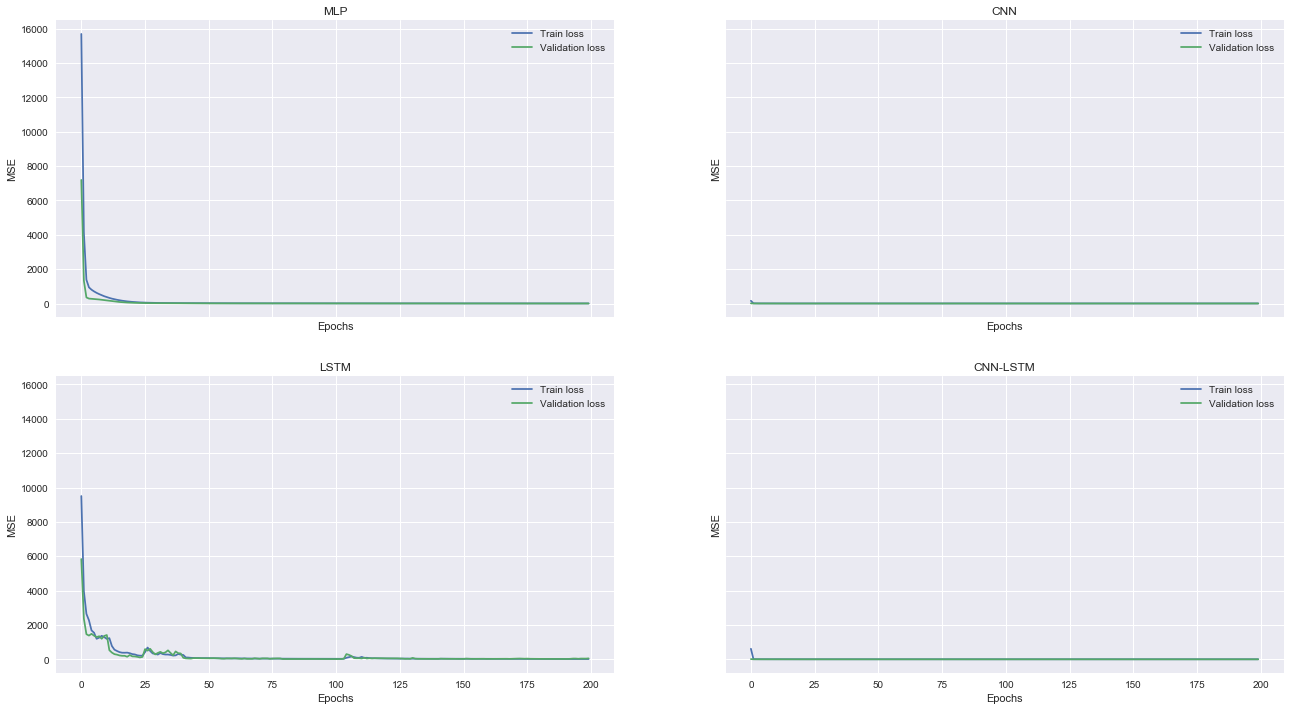

In [44]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

Train rmse: 2.658337122481863
Validation rmse: 2.246714311732809


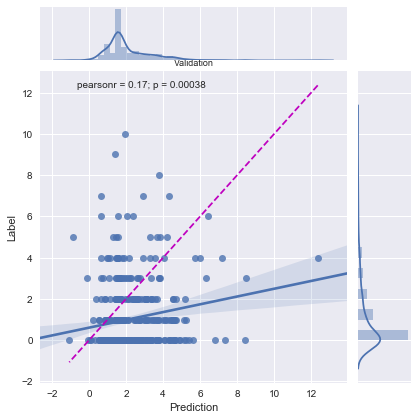

In [49]:
mlp_train_pred = model_mlp.predict(mlp_train.values)
mlp_valid_pred = model_mlp.predict(mlp_val.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, mlp_valid_pred)))
model_performance_sc_plot(mlp_valid_pred, Y_validation, 'Validation')

Train rmse: 2.4660649518757025
Validation rmse: 1.9649694750429332


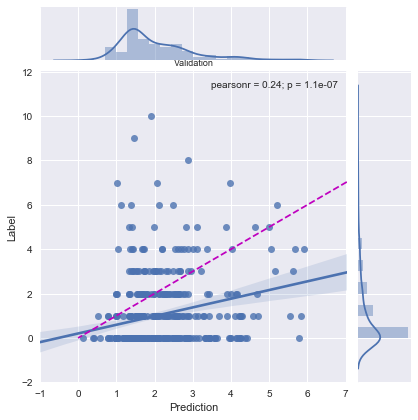

In [50]:
cnn_train_pred = model_cnn.predict(mlp_train_series)
cnn_valid_pred = model_cnn.predict(mlp_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, cnn_valid_pred)))
model_performance_sc_plot(cnn_valid_pred, Y_validation, 'Validation')

Train rmse: 4.972275185894194
Validation rmse: 7.5871566100704975


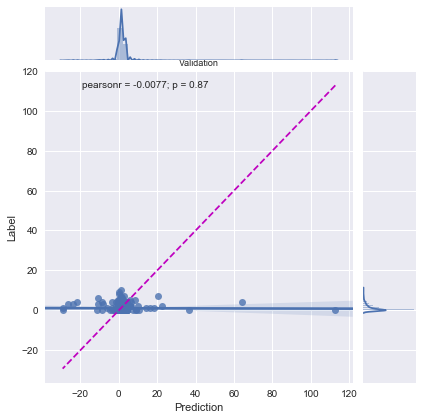

In [51]:
lstm_train_pred = model_lstm.predict(mlp_train_series)
lstm_valid_pred = model_lstm.predict(mlp_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lstm_valid_pred)))
model_performance_sc_plot(lstm_valid_pred, Y_validation, 'Validation')

Train rmse: 2.3277218712411543
Validation rmse: 1.5564759932712355


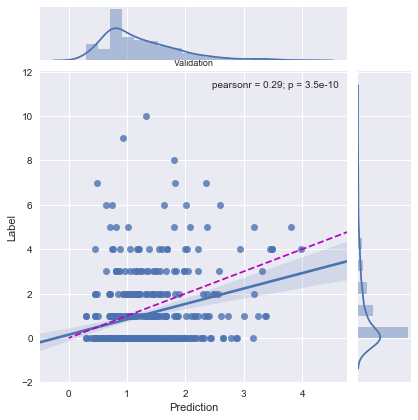

In [52]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, cnn_lstm_valid_pred)))
model_performance_sc_plot(cnn_lstm_valid_pred, Y_validation, 'Validation')